# Gaussian Classifier for MNIST

This paper will document the implementation of a handwritten digit recognition system using a Gaussian generative model. We will use the mnist dataset which can be obtained from: 
                          http://yann.lecun.com/exdb/mnist/index.html
                          
## MNIST Summary

Mnist has 60k training examples and 10k test examples. For this model we have 10 classes to classify: `0, 1, 2, 3, 4, 5, 6, 7, 8, 9`, which represents the digits 0-9. Each example in mnist is a 28x28 image represented by 784 features. Each class will modeled by a multivariate 784-dimensional gaussian. In other words we have a 784-dimensional feature vector and 10 768 degree multivariate gaussians.

# Iris

Before we get started on mnist, lets work on a smaller scale w/ the iris dataset. 4 Features/target. 4 classes. So each class would have a 4D M-Gaussian. This is actually a really good model for IRIS b/c gaussians follow the random patterns in nature and iris is samples from nature.

In [2]:
import math
import matplotlib.pyplot as plt
%pylab inline
import numpy as np
from sklearn import datasets
iris = datasets.load_iris()
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(iris.data, iris.target)

Populating the interactive namespace from numpy and matplotlib


GaussianNB()

As you can see from the Iris data, we have 150 examples, with 3 total classes. Therefore the class priori or $π_j = 1/3$

In [3]:
print gnb.classes_
print gnb.class_count_
print gnb.class_prior_
print gnb.sigma_ # variance of each feature per class -- not Sigma in the context of covariance matrix

[0 1 2]
[ 50.  50.  50.]
[ 0.33333333  0.33333333  0.33333333]
[[ 0.121764  0.142276  0.029504  0.011264]
 [ 0.261104  0.0965    0.2164    0.038324]
 [ 0.396256  0.101924  0.298496  0.073924]]


Now, what scikit did was to fit a gaussian to each of the classes (3) in the training set examples. It does that by finding the mean and the covariance from the examples. Let the Gaussian for the jth class be: $P_j = N(\mu_j, \Sigma_j)$.

$\DeclareMathOperator*{\argmax}{arg\,max}$
Then in order to classify an unknown flower, simply use the class prior w/ the class posterior (bayes rule) fo all the classes and choose the one w/ the largest probability:

$$\argmax_j \pi_j*P_j$$

In [4]:
y_pred = gnb.predict(iris.data)
print("Number of mislabeled points out of a total %d points : %d" % (iris.data.shape[0],(iris.target != y_pred).sum()))

Number of mislabeled points out of a total 150 points : 6


Easy huh? Now, the devil is in the details: how do you calculate $P_j$, how do we estimate a gaussian for each class j?

$$P_j = N(\mu_j, \Sigma_j)$$

We know that $p(\hat{x})$, the probability density function (PDF) of a multivariate Gaussian is this standard form:

$$
p(\hat{x}) = \frac{1}{\sqrt{(2 \pi)^k \det \Sigma}} \exp\left( -\frac{1}{2} (x - \mu)^T \Sigma^{-1} (x - \mu) \right)
$$


Therefore the trick is to tune $\Sigma$, the covariance matrix, to model the training data.

$\Sigma$ is a p x p matrix containing all pairwise covariances, where p is the number of features in your training set:

$$
\Sigma_{ij} = \Sigma_{ji} = cov(X_i, X_j)    if i!=j
$$
$$
\Sigma_{ii} = var(X_i)
$$


$$
\begin{bmatrix}
    var(x_1) & cov(x_1,x_2) & \dots  & x_{1n} \\
    cov(x_2) & var(x_2) & \dots  & x_{2n} \\
    \vdots & \vdots & \ddots & \vdots \\
    x_{d1} & x_{d2} & \dots  & var(x_n)
\end{bmatrix}
$$

Then, given some training points, the way to generate this matrix using numpy: `np.cov(examples, rowvar=0)`

Then, for each target/class (10) you will get a $\mu$ and a $\Sigma$ that you can pop into the numpy PDF routine: `np.random.multivariate_normal`

In [31]:
mean = np.array(examples.mean(0))[0]
cov = np.cov(examples, rowvar=0)
p_x = multivariate_normal(mean=mean, cov=cov)

For iris dataset we will have 4x4 covariance matrix b/c there are 4 features in our training set., here's an example of finding the covariance matrix $\Sigma$ on the iris trainging set. We should be abel to confirm our answer

In [6]:
#lets split into a test and training set
from sklearn.cross_validation import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(iris.data,iris.target, test_size=0.4, random_state=4)

# lets gather all the examples from class 0
def get_examples_for_class(class_id):
    examples = []
    for i, example in enumerate(X_train):
        if Y_train[i]==class_id:
            examples.append(example)
        
    examples = np.matrix(examples)
    return examples

examples = get_examples_for_class(0)
examples.shape

(25, 4)

Now according to the above assertion this should map to a 4x4 covariance matrix. We can use `numpy.cov` to test this assertion and then look at how to implement the equivilent `numpy.cov` in python.

In [7]:
mean = np.array(examples.mean(0))[0]
cov = np.cov(examples.T) # I don't know why you have to transpose the input to numpy... 
print mean
print cov #should be 4x4 for iris

[ 4.964  3.416  1.44   0.24 ]
[[ 0.1049      0.06976667  0.01483333  0.00566667]
 [ 0.06976667  0.10723333  0.00391667  0.00266667]
 [ 0.01483333  0.00391667  0.02583333  0.00625   ]
 [ 0.00566667  0.00266667  0.00625     0.01      ]]


Now we can take this covariance matrix and pipe it into the numpy PDF routine to get our distribution:

In [8]:
from scipy.stats import multivariate_normal

In [9]:
P_0 = np.random.multivariate_normal(mean, cov).T
P_0

var = multivariate_normal(mean=mean, cov=cov)

Now according to equation 1, if we want to classify some vector, X,

$$\argmax_j \pi_j*P_j(X)$$

lets test the probabity the the following test vector is in class 0, or:

$$ \pi_0*P_0(X) $$

where, X is the vector below:

In [10]:
X1=X_test[15]
import random
X1 = random.choice (X_test)
print X1

[ 5.4  3.   4.5  1.5]


In [11]:
prior = pi_0 = gnb.class_prior_[0]
prob_0=[0, var.pdf(X1)]
prob_0

[0, 9.6702924830667242e-90]

$P_1 = N(\mu_1, \Sigma_1)$

In [12]:
#now for class 1
examples_1 = get_examples_for_class(1)
mean_1 = np.array(examples_1.mean(0))[0]
cov_1 = np.cov(examples_1.T)
p_x_1 = multivariate_normal(mean=mean_1, cov=cov_1)
prob_1 = [1, gnb.class_prior_[1] * p_x_1.pdf(X1)]
prob_1

[1, 0.074284709872233928]

In [13]:
#now for class 2
examples_2 = get_examples_for_class(2)
mean_2 = np.array(examples_2.mean(0))[0]
cov_2 = np.cov(examples_2.T)
p_x_2 = multivariate_normal(mean=mean_2, cov=cov_2)
prob_2 = [2, gnb.class_prior_[2] * p_x_2.pdf(X1)]
prob_2

[2, 0.0028397660536565485]

In [14]:
prediction = max(prob_0, prob_1, prob_2, key= lambda a: a[1])
print iris.target_names[prediction[0]]

versicolor


In [15]:
X = iris.data
Y = iris.target
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit(X, Y)

print(iris.target_names[clf.predict([X1])][0])



versicolor


So it seems to be a functioning classifier. Now lets scale this up and test it on the digits dataset.

## Digits

Digits should have 10 classes: 0-9 with each example having 784 (representing 28x28 pixel image). A note: scikit's version of nmist is only 8x8 whereas the original is 28*28. SO as you can see above we have 64 features instead of 784

In [16]:
digits = datasets.load_digits()
X_train, X_test, Y_train, Y_test = train_test_split(digits.data, digits.target, test_size=0.4, random_state=4)
X_train.shape

(1078, 64)

First we need to calculate the prior probabilites of the 10 classes. For the sake of experimentation we just use scikit's NBClassifer to gen these values for us:

In [17]:
helper = GaussianNB()
helper.fit(X_train, Y_train)
classes = helper.classes_
priors = helper.class_prior_
print classes
priors

[0 1 2 3 4 5 6 7 8 9]


array([ 0.09369202,  0.10482375,  0.0974026 ,  0.0974026 ,  0.10575139,
        0.10296846,  0.0974026 ,  0.10018553,  0.09925788,  0.10111317])

So from the above we can see the baysian prior probabilities for the 10 classes 0-9 whick looks like a pretty even distribution.

## Training

Now lets generate the baysian posteror probabilities for each class using the training data.

See this note on the covariance matrix tuning: http://stackoverflow.com/questions/35273908/scipy-stats-multivariate-normal-raising-linalgerror-singular-matrix-even-thou/35293215

We will implement covariance matrix smoothing later, but for now, just set `allow_singular=True`

In [18]:
posteriors=[]

for klass in classes:
    examples = get_examples_for_class(klass)
    mean = np.array(examples.mean(0))[0]
    cov = np.cov(examples.T)
    p_x = multivariate_normal(mean=mean, cov=cov)
    posteriors.append(p_x)

## Classification

Now that we have the prior and posterior probabilities for our training set, lets use that to make a prediction:

In [19]:
#choose a random point from the test data
x = random.choice (X_test)
print x

[  0.   0.   3.  14.  13.  12.  14.   0.   0.   0.  11.  14.  12.  15.   9.
   0.   0.   0.  16.   5.   3.  16.   2.   0.   0.   1.   9.   1.  10.  12.
   0.   0.   0.   0.   0.   7.  16.  14.   6.   0.   0.   0.   4.  16.  16.
  11.   1.   0.   0.   0.   0.  15.   5.   0.   0.   0.   0.   0.   6.  13.
   0.   0.   0.   0.]


In [20]:
bayes_probs = []
for klass in classes:
    prob = [klass, priors[klass] * posteriors[klass].pdf(x)]
    bayes_probs.append(prob)
bayes_probs

[[0, 0.0],
 [1, 1.0140520342536575e-281],
 [2, 0.0],
 [3, 5.5444700721071972e-221],
 [4, 0.0],
 [5, 2.4639081660101053e-208],
 [6, 0.0],
 [7, 8.1408087153194087e-50],
 [8, 1.6042311520465275e-319],
 [9, 1.4456153872364315e-197]]

Notice that the probabilities are VERY small. In this discrete environment we may be losing a lot of percission, so it may be wise to explore using the `log_pdf` instead. We will explore this more later.

Now we choose the max and that is our prediction:

In [21]:
prediction = max(bayes_probs, key= lambda a: a[1])
print digits.target_names[prediction[0]]

7


So our routine predicted a 4, lets visually confirm:

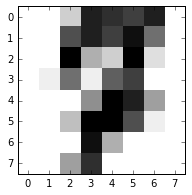

In [22]:
plt.figure(1, figsize=(3, 3))
plt.imshow(x.reshape(8,8), cmap=plt.cm.gray_r, interpolation='nearest')
plt.show()

Success!

## Benchmark

Now lets scale this up and check our error rate

In [23]:
#first I need an interface to batch test, test input (instead of 1 vector at a time, like above)

Y = []
for x in X_test:
    bayes_probs = []
    for klass in classes:
        prob = [klass, priors[klass] * posteriors[klass].pdf(x)]
        bayes_probs.append(prob)
    prediction = max(bayes_probs, key= lambda a: a[1])
    Y.append(prediction[0])



In [24]:
errors = (Y_test != Y).sum()
total = X_test.shape[0]
print("Error rate: %d/%d = %f" % ((errors,total,(errors/float(total)))))

Error rate: 34/719 = 0.047288


Our naievely implemented Gaussian Classifier achinved a 96% success rate.

## Error Analysis

Lets look at the examples our classifier filed on:

In [25]:
def displaychar(image):
    plt.imshow(np.reshape(image, (8,8)), cmap=plt.cm.gray)
    plt.axis('off')

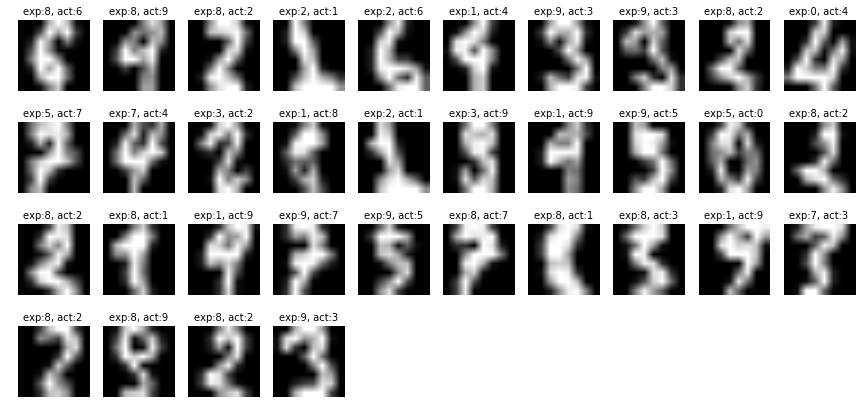

In [26]:
indicies = np.array(np.where((Y_test != Y)==True))[0]

index = 0
rows = len(indicies)%10
cols = 10


plt.figure(figsize=(15,7))
for i in indicies:
    index += 1
    plt.subplot(rows, cols, index)
    displaychar(X_test[i])
    plt.title('exp:%i, act:%i' %( Y[i],Y_test[i]), fontsize = 10)

The above figure shows what the classifier expected and what the actual classification. From the error examples above, some of the examples would even be mistaken by a human.

## Optimizations

The scikit version of mnist is a scaleled down verison. If we run this classifier on the official mnist, we will run into some limititations. The Mnist version has 784 features which digis only has 64 and mnist has more examples: 60,000. At this scale the model starts to have issues taking the determiniate of the coviariance matrix and we also start to have issues w/ underflow in the probabilities. 

### Log Probabilities

The bayes model multiplies very small probabilities and while, therortily there is nothign wrong with this, in our discrete limited-percission evironment, we start to experience underflow and our accuracy decreses. A common fix for this is to update our classification step to use log probabilities:

```
np.log(self.priors[klass]) + self.posteriors[klass].logpdf(x)
```

In [27]:
def predict(self, X):
    Y = []
    for x in X:
        bayes_probs = []
        for klass in self.classes_:
            prob = [klass, np.log(self.priors[klass]) + self.posteriors[klass].logpdf(x)]
            bayes_probs.append(prob)
        prediction = max(bayes_probs, key= lambda a: a[1])
        Y.append(prediction[0])
    return Y

### Covariance Matrix Smoothing

Another common optimization is to add a smoothing factor to the covariance matrix:

$$
\Sigma_j = \Sigma_j * cI
$$

Where $I$ is the identity matrix and $c$ is a constant we must set by tuning against the test data and then apply it to the covariance matrix in the training step:

In [28]:
c = 3500
for klass in classes:
    examples = get_examples_for_class(klass)
    mean = np.array(examples.mean(0))[0]
    cov = np.cov(examples, rowvar=0)
    cov_smoothed = cov + (c * np.eye(mean.shape[0]))
    p_x = multivariate_normal(mean=mean, cov=cov_smoothed)
    posteriors.append(p_x)

Throught experimentation I find that a value around `3500` works well and achives %96 on full mnist.